## Benchmarks

We present some benchmark problems for the B31OS element.

For further references, please see [this](https://doi.org/10.1016/j.engstruct.2021.112239) paper and the references therein.

### Angle Section

![cantilever beam with angle section](Angle.svg)

The cantilever beam with the angle section under an axial load applied at the shear centre.

#### Remarks

1. The section is not rotated.
2. The axial load is applied at the shear centre. The section is defined in the local coordinate system in which the shear centre is the origin.

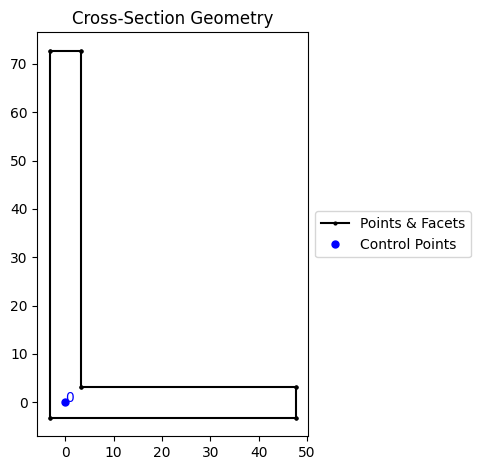

In [1]:
from subprocess import run
import shutil

from sectionproperties.post.fibre import to_fibre_section
from sectionproperties.pre import Geometry

b = 51
t = 6.5
a = 76
points = [(0, 0), (b, 0), (b, t), (t, t), (t, a), (0, a)]

facets = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 0)]

geom = Geometry.from_points(
    points=points, facets=facets, control_points=[(t / 2, t / 2)]
).shift_section(-t / 2, -t / 2)
geom.create_mesh(mesh_sizes=2)
geom.plot_geometry()

to_fibre_section(geom, save_to='angle.sp', material_mapping={'default': 1})

pass

We use the following model to test.

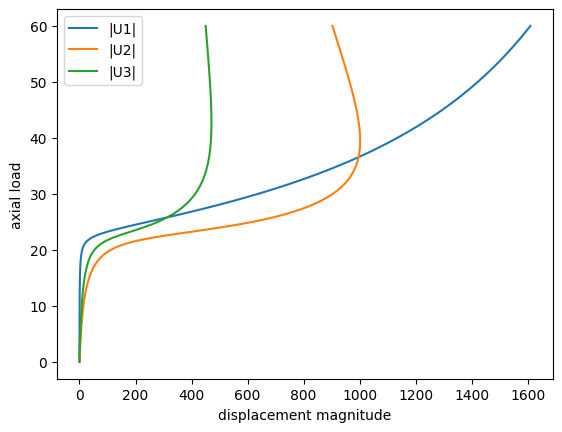

In [2]:
from matplotlib import pyplot as plt
from h5py import File

model = '''# cantilever beam with angle section
node 1 0 0 0
node 2 350 0 0
node 3 700 0 0
node 4 1050 0 0
node 5 1400 0 0

material ElasticOS 1 193.05 .3

file angle.sp

orientation B3DOSC 1 0. 0. -1.

element B31OS 1 1 2 1 1 6 1
element B31OS 2 2 3 1 1 6 1
element B31OS 3 3 4 1 1 6 1
element B31OS 4 4 5 1 1 6 1

fix2 1 E 1

cload 1 0 -60 1 5

hdf5recorder 1 Node U 5

step static 1
set ini_step_size 1E-2
set fixed_step_size true

converger RelIncreDisp 1 1E-10 20 1

analyze

save recorder 1

exit
'''

with open('angle.analysis.sp', 'w') as f:
    f.write(model)

executable = ['suanPan', 'suanPan.exe', 'suanpan']
is_run = False

for exe in executable:
    if shutil.which(exe):
        run([exe, '-f', 'angle.analysis.sp'])
        is_run = True
        break

if is_run:
    with File('R1-U.h5', 'r') as f:
        data = f['R1-U/R1-U5']
        U1 = -data[:, 1]
        U2 = data[:, 2]
        U3 = -data[:, 3]
        LOAD = data[:, 0] * 60
    plt.plot(U1, LOAD, label='|U1|')
    plt.plot(U2, LOAD, label='|U2|')
    plt.plot(U3, LOAD, label='|U3|')
    plt.xlabel('displacement magnitude')
    plt.ylabel('axial load')
    plt.legend()
    plt.show()

### Flat Bar

![cantilever beam with flat bar](Flat.svg)

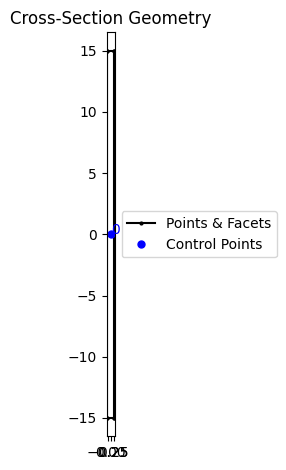

In [3]:
from sectionproperties.pre.library import rectangular_section

geom = rectangular_section(d=30, b=.6).shift_section(-.3, -15)
geom.create_mesh(mesh_sizes=.05)
geom.plot_geometry()

to_fibre_section(geom, save_to='flat.sp', material_mapping={'default': 1})

pass

Here we use the arc-length algorithm to solve the problem.

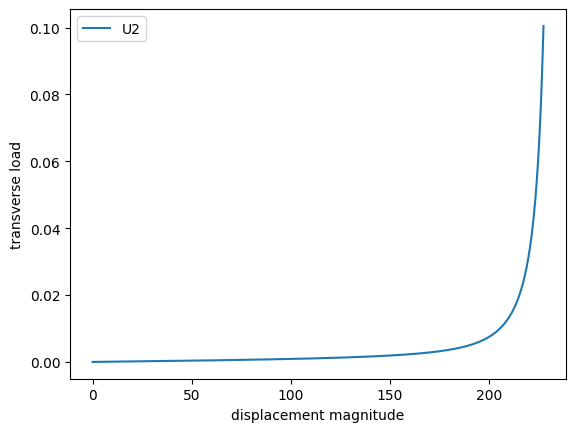

In [4]:
model = '''# cantilever beam with angle section
node 1 0 0 0
node 2 60 0 0
node 3 120 0 0
node 4 180 0 0
node 5 240 0 0

material ElasticOS 1 71.24 .31

file flat.sp

orientation B3DOSC 1 0. 0. -1.

element B31OS 1 1 2 1 1 6 1
element B31OS 2 2 3 1 1 6 1
element B31OS 3 3 4 1 1 6 1
element B31OS 4 4 5 1 1 6 1

fix2 1 E 1

hdf5recorder 1 Node U 5

step arclength 1 5 2 .001
solver Ramm 1 1 true

criterion MaxResistance 1 5 2 .1

converger RelIncreDisp 1 1E-10 20 1

analyze

save recorder 1

exit
'''

with open('flat.analysis.sp', 'w') as f:
    f.write(model)

is_run = False

for exe in executable:
    if shutil.which(exe):
        run([exe, '-f', 'flat.analysis.sp'])
        is_run = True
        break

if is_run:
    with File('R1-U.h5', 'r') as f:
        data = f['R1-U/R1-U5']
        U2 = data[:, 2]
        LOAD = data[:, 0] * .001  # reference load
    plt.plot(U2, LOAD, label='U2')
    plt.xlabel('displacement magnitude')
    plt.ylabel('transverse load')
    plt.legend()
    plt.show()

### Flat Bar Twisting

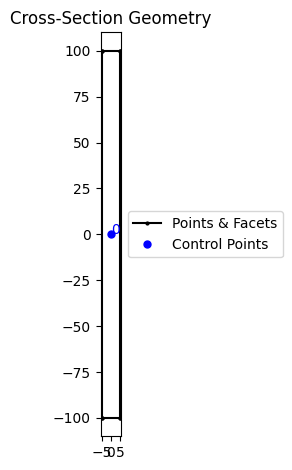

In [5]:
geom = rectangular_section(d=200, b=10).shift_section(-5, -100)
geom.create_mesh(mesh_sizes=2)
geom.plot_geometry()

to_fibre_section(geom, save_to='flat2.sp', material_mapping={'default': 1})

pass

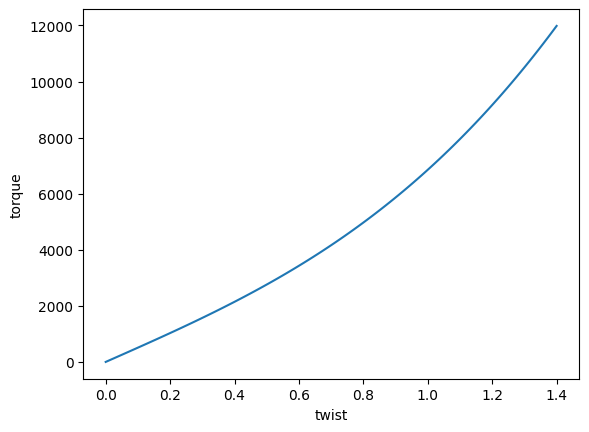

In [6]:
model = '''# cantilever beam with angle section
node 1 0 0 0
node 2 250 0 0
node 3 500 0 0
node 4 750 0 0
node 5 1000 0 0

material ElasticOS 1 200 .25

file flat2.sp

orientation B3DOSC 1 0. 0. -1.

element B31OS 1 1 2 1 1 6 1
element B31OS 2 2 3 1 1 6 1
element B31OS 3 3 4 1 1 6 1
element B31OS 4 4 5 1 1 6 1

fix2 1 E 1

displacement 1 0 1.4 4 5

hdf5recorder 1 Node RF 5

step static 1
set ini_step_size 1E-2
set fixed_step_size true

converger RelIncreDisp 1 1E-10 20 1

analyze

save recorder 1

exit
'''

with open('flat2.analysis.sp', 'w') as f:
    f.write(model)

is_run = False

for exe in executable:
    if shutil.which(exe):
        run([exe, '-f', 'flat2.analysis.sp'])
        is_run = True
        break

if is_run:
    with File('R1-RF.h5', 'r') as f:
        data = f['R1-RF/R1-RF5']
        torque = data[:, 4]
        twist = data[:, 0] * 1.4
    plt.plot(twist, torque)
    plt.xlabel('twist')
    plt.ylabel('torque')
    plt.show()